In [2]:
from dlc_practical_prologue import *
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F


train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(
    1000)


In [3]:
print(train_input.size())

torch.Size([1000, 2, 14, 14])


In [4]:
train_input_norm = (train_input - torch.min(train_input)) / (torch.max(train_input))
test_input_norm = (test_input - torch.min(train_input)) / (torch.max(train_input))

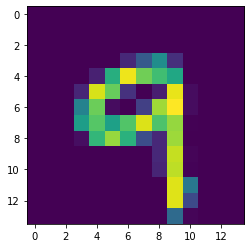

In [120]:
plt.imshow(train_input_norm[550][0])

In [9]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(model))

35896


In [48]:
class Net2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc0 = nn.Flatten()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.25)
        self.fc4 = nn.Linear(32, 10)
        self.fc5 = nn.Linear(10, 1)
        self.fc6 = nn.Linear(2, 1)
        
        self.logsoft = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # INPUT IS A (2, 14, 14) TENSOR, OUTPUT IS (1)
        x = self.fc0(x)
        # (2, 196)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        output1 = self.logsoft(x)
        #x = F.relu(self.fc5(torch.exp(x)))
        #print(x.size())
        
        #print(x.size())
        x = F.relu(self.fc5(x))
        x = torch.flatten(x, 0)
        output2 = self.fc6(x)
        #print(output2)
        return output1, output2


In [39]:
class Net_convo(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, 1, groups=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, groups=2)
        self.fc = nn.Linear(6400, 10)
        self.fc5 = nn.Linear(10, 1)
        self.fc6 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        print(x.size())
        output1 = F.log_softmax(x, dim=1)
        return output
    
get_n_params(Net_convo())

73624

## Batches of (2, 14, 14)

In [49]:



model = Net2()

criterion1 = nn.NLLLoss()
criterion2 = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
time0 = time()
epochs = 25

for e in range(epochs):
    running_loss = 0
    for i in range(len(train_input_norm)):


        optimizer.zero_grad()
        #optimizer_aux.zero_grad()
        #print(torch.flatten(train_input_flat.narrow(0, b, mini_batch_size), 1, 2).size())

        output1, output2 = model(train_input_norm[i])

        loss1 = criterion1(output1, train_classes[i])
        loss2 = criterion2(output2, train_target[i].reshape(1).to(torch.float32))
        #print(loss2)

        w2 = 0.1

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()



        running_loss += loss1.item() + loss2.item() * w2

    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(train_input)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    

Epoch 1 - Training loss: 2.370706398501992

Training Time (in minutes) = 0.03946290016174316
Epoch 2 - Training loss: 2.358705683815477

Training Time (in minutes) = 0.07684649626413981
Epoch 3 - Training loss: 2.3039082026898843

Training Time (in minutes) = 0.11465048392613729
Epoch 4 - Training loss: 2.013262138183412

Training Time (in minutes) = 0.15412001609802245
Epoch 5 - Training loss: 1.7056462838789435

Training Time (in minutes) = 0.19278246959050496
Epoch 6 - Training loss: 1.5142114042938677

Training Time (in minutes) = 0.23092281421025593
Epoch 7 - Training loss: 1.3281400516172865

Training Time (in minutes) = 0.26895553270975747
Epoch 8 - Training loss: 1.1745112902824135

Training Time (in minutes) = 0.3065964897473653
Epoch 9 - Training loss: 1.0827492001691497

Training Time (in minutes) = 0.34411661624908446
Epoch 10 - Training loss: 1.0298014087310954

Training Time (in minutes) = 0.38122197389602663
Epoch 11 - Training loss: 0.9533075239107387

Training Time (in

## Batches of (b, 2, 14, 14)

In [40]:

# WITH BATCHES


model = Net_convo()

criterion1 = nn.NLLLoss()
criterion2 = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
time0 = time()
epochs = 25

mini_batch_size = 25

for e in range(epochs):
    running_loss = 0
    for b in range(0, train_input_norm.size(0), mini_batch_size):


        optimizer.zero_grad()
        output1, output2 = model(train_input_norm.narrow(0, b, mini_batch_size))

        loss1 = criterion1(output1, train_classes.narrow(0, b, mini_batch_size))
        loss2 = criterion2(output2, train_target.narrow(0, b, mini_batch_size).to(torch.float32))
        #print(loss2)

        w2 = 0.1

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()



        running_loss += loss1.item() + loss2.item() * w2

    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(train_input)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    

torch.Size([25, 64, 10, 10])
torch.Size([25, 64, 10, 10])
torch.Size([25, 6400])
torch.Size([25, 10])


NameError: name 'output' is not defined

In [22]:
torch.mean(train_input)

tensor(33.1434)

In [50]:
def compute_err_digit_recog(model, test_input_norm, test_classes): # CHANGER LES NOMS SVP

    correct_count_digit, all_count_digit = 0, 0
    correct_count_equal, all_count_equal = 0, 0
    
    for img, label, target, i in zip(test_input_norm, test_classes, 
                                            test_target, range(len(test_classes))):   

        with torch.no_grad():
            log_probs_digits, probs_equality = model(img)
        
        #print(torch.sigmoid(probs_equality), test_target[i])


        probs = torch.exp(log_probs_digits)
        _, preds = torch.max(probs,dim=1)
        true_labels = label

        for predicted, groundtruth in zip(preds, true_labels):
            if(predicted == groundtruth):
                correct_count_digit += 1
            #print(predicted, groundtruth)
            all_count_digit += 1
        
        
        
        if((torch.sigmoid(probs_equality) >= 0.5 and target == 1) or 
                   (torch.sigmoid(probs_equality) < 0.5 and target == 0)):
            correct_count_equal += 1
        all_count_equal +=1
        

    print("Number Of Images Tested =", all_count_digit)
    print("\nModel Accuracy =", (correct_count_digit/all_count_digit), '\n\n')
    print("Number Of Inequalities tested =", all_count_equal)
    print("\nModel Accuracy =", (correct_count_equal/all_count_equal))
    
compute_err_digit_recog(model, test_input_norm, test_classes)

Number Of Images Tested = 2000

Model Accuracy = 0.8885 


Number Of Inequalities tested = 1000

Model Accuracy = 0.857


In [ ]:
def compute_nb_errors(model, data_input, data_target):

    correct_count, all_count = 0

    for b in range(0, data_input.size(0), mini_batch_size):
        _, output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            print(data_target[b+k])
            print(predicted_classes[k])
            print("|----|")
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

print(train_input.size())

compute_nb_errors(model, train_input, train_target)


In [46]:
print(len(test_classes_flat))

2000


In [39]:
print(torch.flatten(torch.flatten(test_input_norm, 0, 1), 1, 2).size())

torch.Size([1000, 196])
